# Arduino Demonstration for Two-Layer Fully Connected Nerural Network

## Arduino Code repository

https://github.com/auralius/arduino-linear-classifier/tree/main

Check the `fcnn` folder.

![](./images/demo_fcnn.gif)

## Preparations

As usual, let's start with some preparations.

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=5, suppress=True)

Put the previous `TwoLayerNet` class here so that we can use it easily to train our classifier.

### The TwoLayerNet class

In [4]:
class TwoLayerNet():
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """


    def __init__(self, input_size, hidden_size, output_size, std=1e-5):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)


    @staticmethod
    def loss(W1, b1, W2, b2, X, Y, reg=0.0, grad=False):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - Y: Vector of training labels. Y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= Y[i] < C. This parameter is optional; if it
        is not passed then we only return scores, and if it is passed then we
        instead return the loss and gradients.
        - reg: Regularization strength.
        - grad: flag to or NOT to return the loss gradients

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
        samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
        with respect to the loss function; has the same keys as self.params.
        """
        N, D = X.shape

        # Compute the forward pass
        fc1 = X.dot(W1) + b1     # fully connected
        X2 = np.maximum(0, fc1)  # ReLU
        F = X2.dot(W2) + b2 # fully connected
        
        # Compute the loss 
        F = F - np.max(F, axis=1).reshape(-1,1)
        expF = np.exp(F)
        softmax = expF/np.sum(expF, axis=1).reshape(-1,1) 
        loss = np.sum(-np.log(softmax[range(N),Y])) / N + reg  * (np.sum(W2 * W2) + np.sum( W1 * W1 ))
        
        if grad == True: # loss gradient is optionals
            # Backward pass: compute gradients
            softmax[np.arange(N) ,Y] -= 1
            softmax /= N

            # W2 gradient
            dW2 = X2.T.dot(softmax)   # [HxN] * [NxC] = [HxC]

            # b2 gradient
            db2 = softmax.sum(axis=0)

            # W1 gradient
            dW1 = softmax.dot(W2.T)   # [NxC] * [CxH] = [NxH]
            dfc1 = dW1 * (fc1>0)      # [NxH] . [NxH] = [NxH]
            dW1 = X.T.dot(dfc1)       # [DxN] * [NxH] = [DxH]

            # b1 gradient
            db1 = dfc1.sum(axis=0)

            # regularization gradient
            dW1 += reg * 2 * W1
            dW2 += reg * 2 * W2

            dW = np.hstack((dW1.flatten(), db1, dW2.flatten(), db2))
        
            return (loss, dW)
        
        return loss


    def train(self, X, Y, reg=1e-5, gtol=1e-5, maxiter=1000, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
        X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - verbose: boolean; if true print progress during optimization.
        """
        self.params["loss_history"] = []

        D, H = self.params['W1'].shape
        H, C = self.params['W2'].shape

        def obj(x):
            W1 = x[0: D*H].reshape(D,H)
            b1 = x[D*H: D*H+H]
            W2 = x[D*H+H: D*H+H+(H*C)].reshape(H,C)
            b2 = x[D*H+H+(H*C):]

            loss = self.loss(W1, b1, W2, b2, X, Y, reg=reg, grad=True)
            self.params["loss_history"].append(loss[0])

            if verbose == True:
                print(loss)

            return loss

        x0 = np.hstack((self.params['W1'].flatten(), 
                        self.params['b1'], 
                        self.params['W2'].flatten(), 
                        self.params['b2']))
        res = minimize(obj, x0, method='L-BFGS-B', jac=True, options={'gtol': gtol, 'maxiter': maxiter, 'disp': True})

        self.params["W1"] = res.x[0: D*H].reshape(D,H)
        self.params["b1"] = res.x[D*H: D*H+H]
        self.params["W2"] = res.x[D*H+H: D*H+H+(H*C)].reshape(H,C)
        self.params["b2"] = res.x[D*H+H+(H*C):]
    

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - Y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """

        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        # Compute the forward pass
        fc1 = X.dot(W1) + b1     # fully connected
        X2 = np.maximum(0, fc1)  # ReLU
        scores = X2.dot(W2) + b2 # fully connected
    
        y_pred = np.argmax( scores, axis=1)
        
        return y_pred

## USPS Dataset

The USPS dataset is a little more suitable for our implementation then the MNIST dataset. Images in the USPS dataset are wrapped as tightly as possible inside their bounding boxes. Thus, every image is centered at the center of its bounding box. As for images in the MNIST dataset, they are not tightly wrapped. Each image is centered its center of mass. Finding center of mass of an image is considerably very resource demanding for a general low-cost microcontoller that we will use.

The USPS dataset can be found here:

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#usps


In [5]:
import h5py
with h5py.File("./datasets/usps/usps.h5", 'r') as hf:
    X_train = hf.get("train").get('data')[:] * 255.0
    Y_train = np.int32(hf.get("train").get('target')[:]) 

    X_test = hf.get("test").get('data')[:] * 255.0
    Y_test = np.int32(hf.get("test").get('target')[:]) 

print("Training data")
print("Dimension numbers :", X_train.shape[1])
print("Number of data    :", X_train.shape[0])
print("Labels            :", np.unique(Y_train))

print("Test data")
print("Dimension numbers :", X_test.shape[1])
print("Number of data    :", X_test.shape[0])
print("Labels            :", np.unique(Y_test))

# For the NN
input_size  = X_train.shape[1]
num_classes = len(np.unique(Y_train))

Training data
Dimension numbers : 256
Number of data    : 7291
Labels            : [0 1 2 3 4 5 6 7 8 9]
Test data
Dimension numbers : 256
Number of data    : 2007
Labels            : [0 1 2 3 4 5 6 7 8 9]


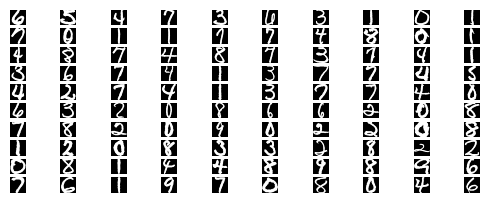

In [6]:
for i in range(100):
    X_train_ = X_train[i,:].reshape(16, 16)
    X_train_ = np.abs(255.0 - X_train_)
    plt.subplot(20, 10, i + 1)
    # Rescale the weights to be between 0 and 255
    plt.imshow(X_train_.astype('uint8'), cmap='Greys')
    plt.axis('off')

## Training

* `input_size = 256`, the resolution of the image is 16x16
* `hidden_size = 50`, this is a tunable hyperparameter
* `num_classes = 10`, 10 classes: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
* `reg = 0.01`, this is anothe tunable hyperparameter

In [22]:
hidden_size = 50

net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train, Y_train, reg=0.5, gtol=1e-3, maxiter=100, verbose=False)

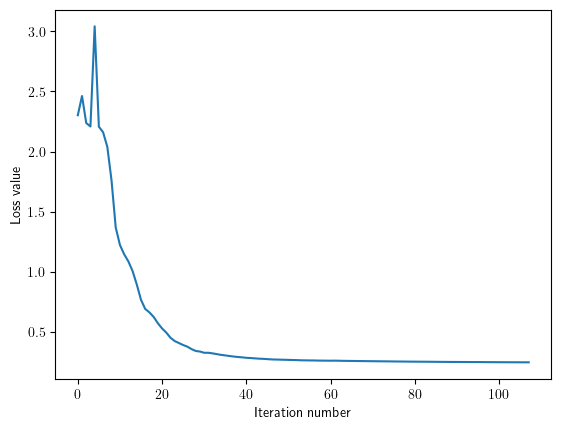

In [23]:
plt.plot(net.params["loss_history"])
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

## Testing

In [24]:
# Predict on the validation set
train_acc = (net.predict(X_train) == Y_train).mean()
print('Training accuracy : ', train_acc)

# Predict on the test set
test_acc = (net.predict(X_test) == Y_test).mean()
print('Test accuracy     : ', test_acc)

Training accuracy :  0.9798381566314635
Test accuracy     :  0.931738913801694


## Save the matrix

Since we are using the "bias trick" in the Arduino, we will bundle the weight matrix and its corresponding bias vector together. Next, considering what we want to do is: `x@W`, we will store `W.transpose()`. The reason is because single indexing of a 2D-array is done in a row-major order. Additionally, each line must be NULL terminated.

In [25]:
np.savetxt('W1.txt', np.float16(np.hstack((net.params["W1"].transpose(), net.params['b1'].reshape(-1,1)))), delimiter='\0\n', fmt='%.1e', newline='\0\n')
np.savetxt('W2.txt', np.float16(np.hstack((net.params["W2"].transpose(), net.params['b2'].reshape(-1,1)))), delimiter='\0\n', fmt='%.1e', newline='\0\n')

Let's check te dimenstion and make sure they make sense.

In [26]:
np.float16(np.hstack((net.params["W1"].transpose(), net.params['b1'].reshape(-1,1)))).shape

(50, 257)

In [27]:
np.float16(np.hstack((net.params["W2"].transpose(), net.params['b2'].reshape(-1,1)))).shape

(10, 51)

Things are loking good. We can copy W1.txt and W2.txt to the SD card.